# What is Orthogonal Machine learning?

1. It's a technique used to estimate causal effects in observational studies
2. The basis of the technique is the decomposition of linear regression into 3 steps by Frisch-Waugh-Lovell (FWL)
3. The decomposition allows us to replace the steps taken in FWL with any machine learning regression methods

# Frisch-Waugh-Lovell Theorem
## Making Multivariate Regression Interpretation Intuitive

When given a univariate regression equation in the form <br><br>

$
y_i = \alpha + \beta x_i + \varepsilon_i
$<br>
<br>
we can visualize that the regression plot will have a line with slope $\beta$ and intercept $\alpha$, with residuals $\varepsilon$. In the case of randomly controlled trial (RCT) / A/B test, if $x$ is the treatment condition, you can interpret $\beta$ as the coefficient for the effect of $x$ on $y$.<br><br>

If you didn't have an A/B test though, you can't interpret the regression coefficient as the effect of $x$ on $y$ because of selection bias.

One of the most used ways to control for the selection bias is by using multivariate regression and including all the biasing factors in the regression, so the multivariate regression equation is in the form <br><br>

$
y_i = \beta_1 x_{i,1} + \beta_2 x_{i,2} + ... + \beta_n x_{i,n} + \varepsilon_i
$ <br>
<br>
where $x_2$ to $x_n$ are all the biasing factors. The interpretation for the coefficient $\beta_1$ becomes the effect of $x_1$ on $y$ holding $x_2$ to $x_n$ constant. How does it do that though?<br><br>

This is where Frisch-Waugh-Lovell (FWL) theorem comes in. FWL allows us to decompose multivariate regressions into 3 steps which will help to understand better what is happening under the hood.

*   regress $x_1$ on $x_2$ to $x_n$ and retrieve the residuals $\tilde x_1$
*   regress $y$ on $x_2$ to $x_n$ and retrieve the residuals $\tilde y$
*   regress $\tilde y$ on $\tilde x_1$ and retrieve the coefficient on $\tilde x_1$ <br>
<br>

Why are we using the residuals? If you remember back to undergraduate regression theory, when you regress $y$ on $x$ the residuals $\varepsilon$ is no longer correlated with the regressor $x$, so the residuals are independent of the regressor. **The residuals can be interpreted as the part of $y$ which is not affected by $x$.**

Lets run through an example







### Example

### Load Packages, Settings & DGP

In [1]:
#@title
# import helper libraries
import pandas as pd
import numpy as np

#import stats libraries
import statsmodels.formula.api as smf
from scipy.stats import gamma

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#@title
pd.set_option('display.max_columns', None)

In [3]:
#@title
def generate_data(seed=1, N=300, K=5):

    np.random.seed(seed)

    # visit history
    visitHistory = np.round(np.random.normal(10,5,N),0)
    visitHistory[visitHistory<0] = 0

    # trx history
    trxHistory = np.round(.2*visitHistory * np.random.normal(5,2,N),0)
    trxHistory[trxHistory<0] = 0

    # SkuAvailability in terms of oos pct
    skuAvailability = np.random.normal(0.7,0.1,N)

    # number of sales visit
    salesVisit = np.round(visitHistory * 0.2 + trxHistory * 0.1 +
                          np.random.normal(1,1, N), 0)
    salesVisit[salesVisit<0] = 0

    # Sales
    sales = np.round(5000 * salesVisit + 20000 * visitHistory +
                     10000 * trxHistory + 200000 * skuAvailability +
                     np.random.normal(20000,5000,N),0)

    # Generate the dataframe
    df = pd.DataFrame({'visitHistory': visitHistory,
                       'trxHistory': trxHistory,
                       'skuAvailability': skuAvailability,
                       'salesVisit': salesVisit,
                       'sales': sales})

    return df

In [8]:
#@title
def regplot(x,y,x_label,y_label,residuals=True, annotate=False):

    import statsmodels.api as sm
    # regression line
    mod = sm.OLS(y,sm.add_constant(x))
    res = mod.fit()
    y_hat = res.predict()
    m = res.params[1]

    # bukalapak color palette #E31E52 #FFA3A6 #3838A8 #F4A62A #C62B0C #034430 #142568 #FFE67D #B7EDB7 #C7F9F0 #E5D9BD #CCD2DB
    COLOR1 = '#E31E52'
    COLOR2 = '#3838A8'
    COLOR3 = '#FFA3A6'

    fig, ax1 = plt.subplots(facecolor='white',figsize=(12,8))
    ax1.set_xlabel(x_label, fontsize=14)
    ax1.set_ylabel(y_label, fontsize=14)
    ax1.tick_params(axis='x',labelrotation=90, labelsize=8)

    scatter = ax1.scatter(x,
                          y,
                          color=COLOR1)

    regline = ax1.plot(x,
                       y_hat,
                       color=COLOR2,
                       linestyle=':')

    if residuals == True:
      vlines = ax1.vlines(x,
                          np.minimum(y,y_hat),
                          np.maximum(y,y_hat),
                          linestyle='--',
                          color=COLOR3)

    ticks_loc = ax1.get_yticks().tolist()

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_color('#dddddd')
    ax1.spines['left'].set_color('#dddddd')

    if annotate == True:
      for line, name in zip(ax1.lines, [round(m,2)]):
          y_pos = line.get_ydata()[-1]
          x_pos = line.get_xdata()[-1]
          ax1.annotate(f'slope={name}',
                        xy=(x_pos,y_pos),
                        xytext=(1,0),
                        color=line.get_color(),
                        textcoords="offset points",
                        size=12,
                        va="center")
    else:
      pass
    plt.show()

To initially demonstrate this, we will generate a fictional data with a pre-determined data generating process (DGP).

Mitra Bukalapak uses sales army to visit mitra to nudge them to transact. The sales team would like to understand, what is the effect of visit on sales.

The DGP follow the following causal diagram:<br>
<br>

[![](https://mermaid.ink/img/pako:eNqFkTFvgzAQhf-K5S5EIkPTshCpEg2RkNouJfXk5YKPxooxyDZJUJT_XkMKTbvUXp6_s5_u-c60qAXSmJaqPhY7MI68vnPNdaHA2hRLgqdCtQIFKaVS8d1qlS7S59A6U-_xz3F-lMLt4kVzWt4YtLreWjSHyaIc1n8WIxBgfVsGuphEJFr2veUsCHJQaAmTVrrZzKNv0utNFgQbcyKZtK42XY-YR0nTXO_fFhL_7uWDJAeQCrZSSTfgfrOMzOdPZJP1joPM2Y-c6j1kE8zZqJJRcK2k3ueuU-gTjKnXD_fraPE79aP_OBrSCk0FUvihnLkmhFO3wwo5jb0UWEKrHKdcX_xVaF2dd7qgcQnKYkjbRoDDVMKngWqiKKQP_Had9DDwyxedzqcR?type=png)](https://mermaid.live/edit#pako:eNqFkTFvgzAQhf-K5S5EIkPTshCpEg2RkNouJfXk5YKPxooxyDZJUJT_XkMKTbvUXp6_s5_u-c60qAXSmJaqPhY7MI68vnPNdaHA2hRLgqdCtQIFKaVS8d1qlS7S59A6U-_xz3F-lMLt4kVzWt4YtLreWjSHyaIc1n8WIxBgfVsGuphEJFr2veUsCHJQaAmTVrrZzKNv0utNFgQbcyKZtK42XY-YR0nTXO_fFhL_7uWDJAeQCrZSSTfgfrOMzOdPZJP1joPM2Y-c6j1kE8zZqJJRcK2k3ueuU-gTjKnXD_fraPE79aP_OBrSCk0FUvihnLkmhFO3wwo5jb0UWEKrHKdcX_xVaF2dd7qgcQnKYkjbRoDDVMKngWqiKKQP_Had9DDwyxedzqcR)

$
Visit_{App} \sim N(\mu_{visitApp},\sigma_{visitApp}) \\
Trx \sim f(Visit_{App}) + \varepsilon_{trx}, \;\varepsilon_{trx} \sim N(\mu_{trx},\sigma_{trx}) \\
SkuAvailability \sim N(\mu_{sku},\sigma_{sku}) \\
Visit_{sales} = f(Visit_{App}, Trx) + \varepsilon_{visitSales}, \;\varepsilon_{visitSales} \sim N(\mu_{visitSales},\sigma_{visitSales}) \\
sales = g(Visit_{sales}, Visit_{app}, Trx, SkuAvailability) + \varepsilon_{sales}, \;\varepsilon_{sales} \sim N(\mu_{sales}, \sigma_{sales})\\
$<br>

N : normal distribution with mean $\mu$ and std deviation $\sigma$ <br>

Essentially:
- Sku Availability & App Visit History are independent
- Trx History is dependent on App Visit History
- Sales Visit is dependent on App Visit History & Trx History
- Sales is dependent on Sales Visit, App Visit History, Trx History, and Sku Availability

Assumptions:
- We assume normal distributions for this exercise because it's easier to visualize, however the method applies also if the outcome and covariates follow other distributions.
- Trx and App visit history can include RFM metrics, but for this example it will only be based on frequency.


In [5]:
df = generate_data(seed = 6, N=200)
df.head()

,visitHistory,trxHistory,skuAvailability,salesVisit,sales
0,8.0,6.0,0.700528,2.0,389434.0
1,14.0,20.0,0.696381,5.0,666882.0
2,11.0,5.0,0.838719,5.0,478309.0
3,6.0,10.0,0.592677,4.0,374661.0
4,0.0,0.0,0.585267,0.0,130831.0


If we regress sales on sales visit without conditioning on other variables

In [6]:
mod = smf.ols('sales ~ salesVisit', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     425.2
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           3.44e-51
Time:                        07:19:27   Log-Likelihood:                -2554.3
No. Observations:                 200   AIC:                             5113.
Df Residuals:                     198   BIC:                             5119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.938e+05   1.54e+04     12.579      0.0

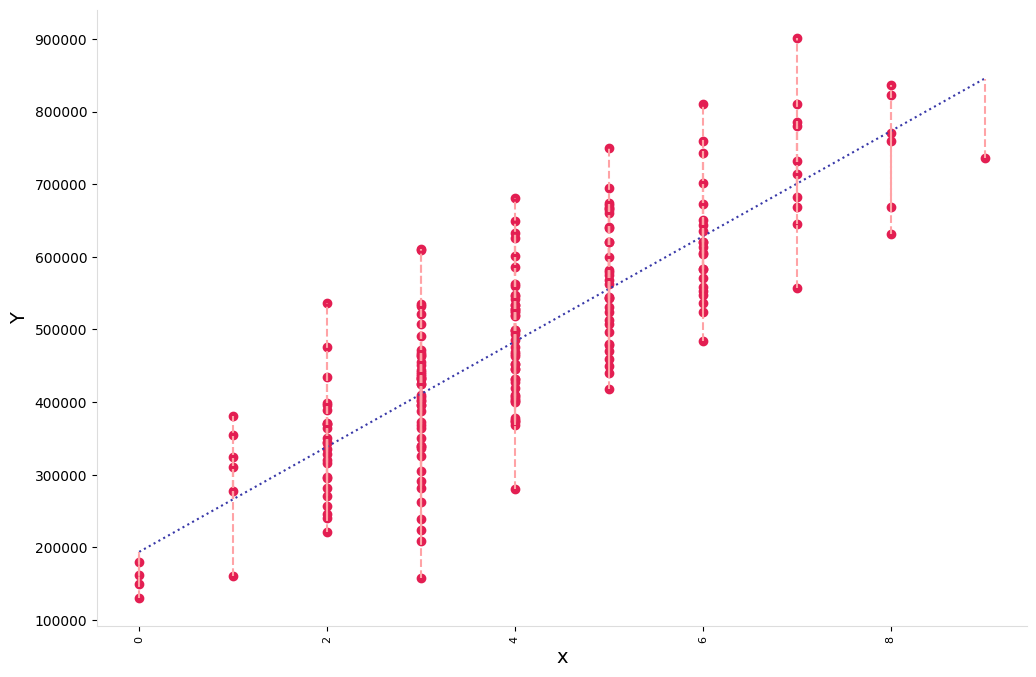

In [11]:
regplot(x=df.sort_values('salesVisit')['salesVisit'],
        y=df.sort_values('salesVisit')['sales'],
        x_label = 'Sales Visit',
        y_label = 'Sales')

If we try to naively evaluate the impact of sales visit on sales by regressing sales on sales visit, we gain average of 79k for every sales visit sent to a user.

We know that in this case that the estimate is highly biased, because in the DGP we specified, there is a backdoor from visit and trx history to sales where the history values affects both sales visit and sales, where higher visit & trx history values results in higher sales visit sent and higher sales.

[![](https://mermaid.ink/img/pako:eNqFkcFuwjAMhl_Fyi5FKgcKXIo0qaNIlbZdVtZTLqFxR0SaVkkKVIh3X1rWwnZZcvnz2f5lxxeSVxxJSApZnfI90xbePqiiKpfMmBgLwHMuG44cCiFl-LRex0H84hurqwP-eU5Pgtt9GNTn1YNBo6qdQX0cLYr-_GcxAM6Ma0uzNoQlLFddb2nmeSmTaCATRtjJxKEf0ult4nlbfYZEGFvptkOZQ1Fd3_IfA5Gre_2E6MiEZDshhe1xd7MEptNn2CadYy_T7C7HeAezEabZoKJBUCWFOqS2lQgzP_Dn_gKG2Tfz2WYZ_J594b6P-KREXTLB3WouVAFQYvdYIiWhkxwL1khLCVVXl8oaW6WtyklYMGnQJ03NmcVYsC_NypEiF27s99u--7VfvwEN6qgq?type=png)](https://mermaid.live/edit#pako:eNqFkcFuwjAMhl_Fyi5FKgcKXIo0qaNIlbZdVtZTLqFxR0SaVkkKVIh3X1rWwnZZcvnz2f5lxxeSVxxJSApZnfI90xbePqiiKpfMmBgLwHMuG44cCiFl-LRex0H84hurqwP-eU5Pgtt9GNTn1YNBo6qdQX0cLYr-_GcxAM6Ma0uzNoQlLFddb2nmeSmTaCATRtjJxKEf0ult4nlbfYZEGFvptkOZQ1Fd3_IfA5Gre_2E6MiEZDshhe1xd7MEptNn2CadYy_T7C7HeAezEabZoKJBUCWFOqS2lQgzP_Dn_gKG2Tfz2WYZ_J594b6P-KREXTLB3WouVAFQYvdYIiWhkxwL1khLCVVXl8oaW6WtyklYMGnQJ03NmcVYsC_NypEiF27s99u--7VfvwEN6qgq)

Now let's regress sales on notification and visit & trx history, since we know that trx & visit history are confounders.

In [ ]:
mod = smf.ols('sales ~ salesVisit + visitHistory + trxHistory', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3964.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          4.12e-175
Time:                        06:17:15   Log-Likelihood:                -2256.8
No. Observations:                 200   AIC:                             4522.
Df Residuals:                     196   BIC:                             4535.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.599e+05   3596.866     44.466   

The coefficient on voucher is now 5129, closer to the 5000 given by the DGP. It's not exactly 5000, because we introduce some randomness to the data generating process.

Lets try to run this regression using FWL regression decomposition.

Steps:
1. regress sales on visit & trx History and get the residuals
2. regress sales visit on visit & Trx history and get the residuals
3. regress sales residuals on sales visit residuals

In [13]:
# step 1 - get residuals from regressing sales on visit & trx history
df['salesHistoryResiduals'] = smf.ols('sales ~ visitHistory + trxHistory', data=df).fit().resid
# step 2 - get residuals from regressing notification on visit & trx history
df['salesVisitHistoryResiduals'] = smf.ols('salesVisit ~ visitHistory + trxHistory', data=df).fit().resid
# step 3 - regress sales residuals on sales visit residuals
mod = smf.ols('salesHistoryResiduals ~ salesVisitHistoryResiduals', data=df)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     salesHistoryResiduals   R-squared:                       0.067
Model:                               OLS   Adj. R-squared:                  0.062
Method:                    Least Squares   F-statistic:                     14.12
Date:                   Wed, 14 Jun 2023   Prob (F-statistic):           0.000226
Time:                           08:04:58   Log-Likelihood:                -2256.8
No. Observations:                    200   AIC:                             4518.
Df Residuals:                        198   BIC:                             4524.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

voila, you get the same exact regression coefficient and standard error

let's visualize the residuals

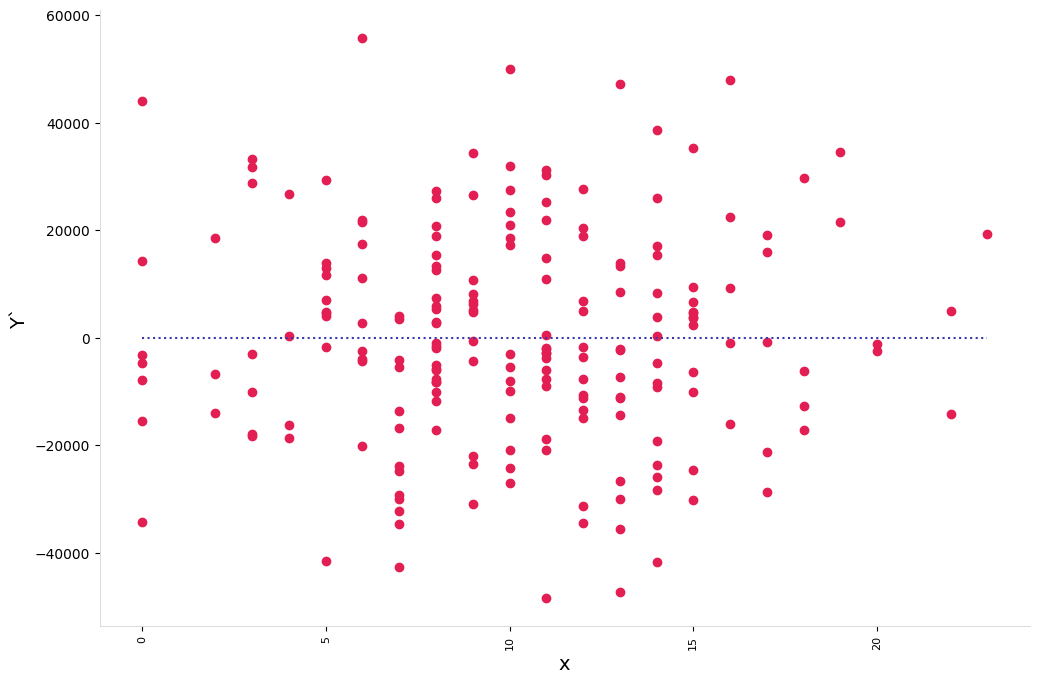

In [15]:
regplot(x=df.sort_values('visitHistory')['visitHistory'],
        y=df.sort_values('visitHistory')['salesHistoryResiduals'],
        x_label = 'visitHistory',
        y_label = 'sales residuals',
        residuals=False)

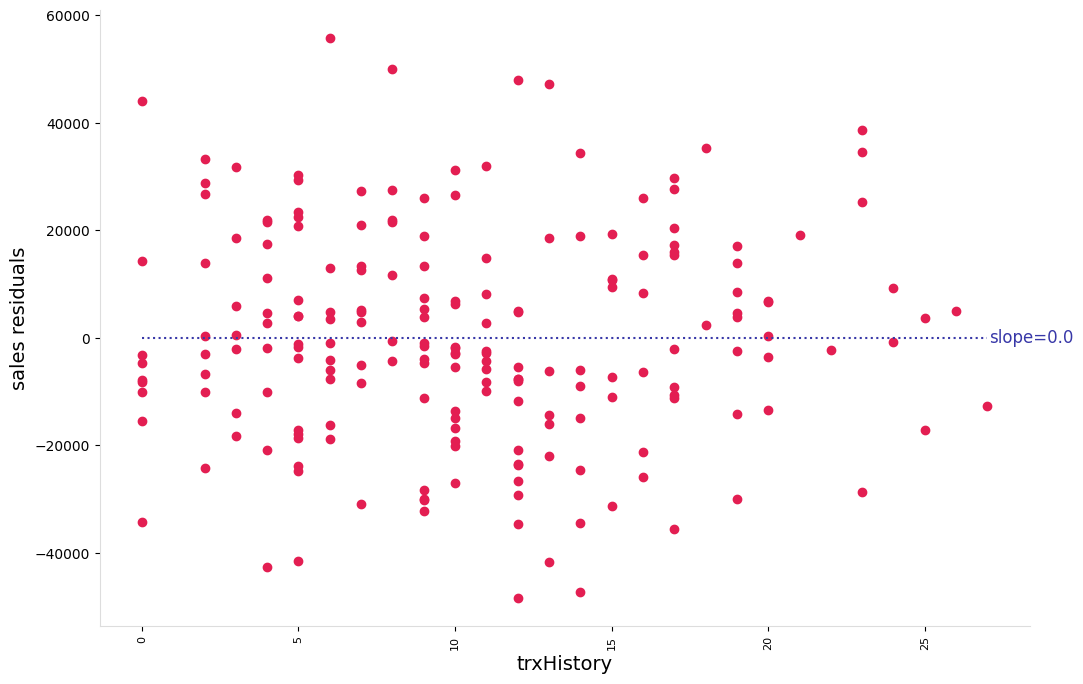

In [ ]:
regplot(x=df.sort_values('trxHistory')['trxHistory'],
        y=df.sort_values('trxHistory')['salesHistoryResiduals'],
        x_label = 'trxHistory',
        y_label = 'sales residuals',
        residuals=False)

the sales residuals is no longer correlated with visit & trx history, meaning the sales residuals is the part of sales which is not dependent on visit & trx history.

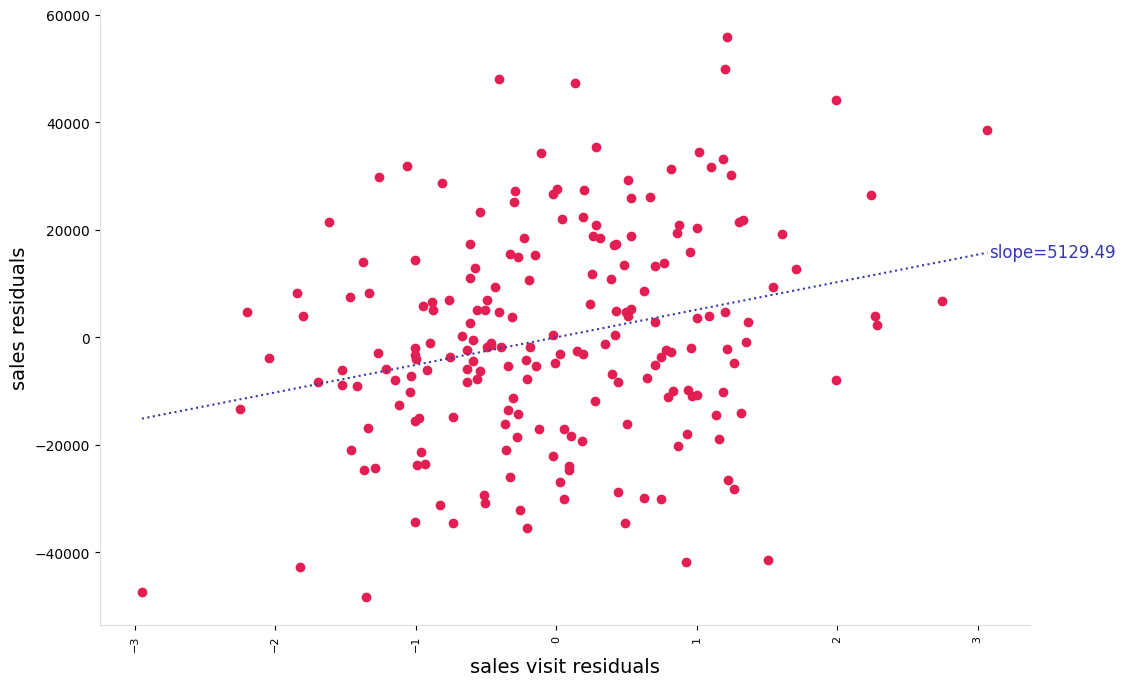

In [ ]:
regplot(x=df.sort_values('salesVisitHistoryResiduals')['salesVisitHistoryResiduals'],
        y=df.sort_values('salesVisitHistoryResiduals')['salesHistoryResiduals'],
        x_label = 'sales visit residuals',
        y_label = 'sales residuals',
        residuals=False)

The plot interpretation gets a little weird, because you can't have negative sales visit or sales. This is because residuals have a mean of 0. In order to make it make sense more, we can add the mean to the residuals.

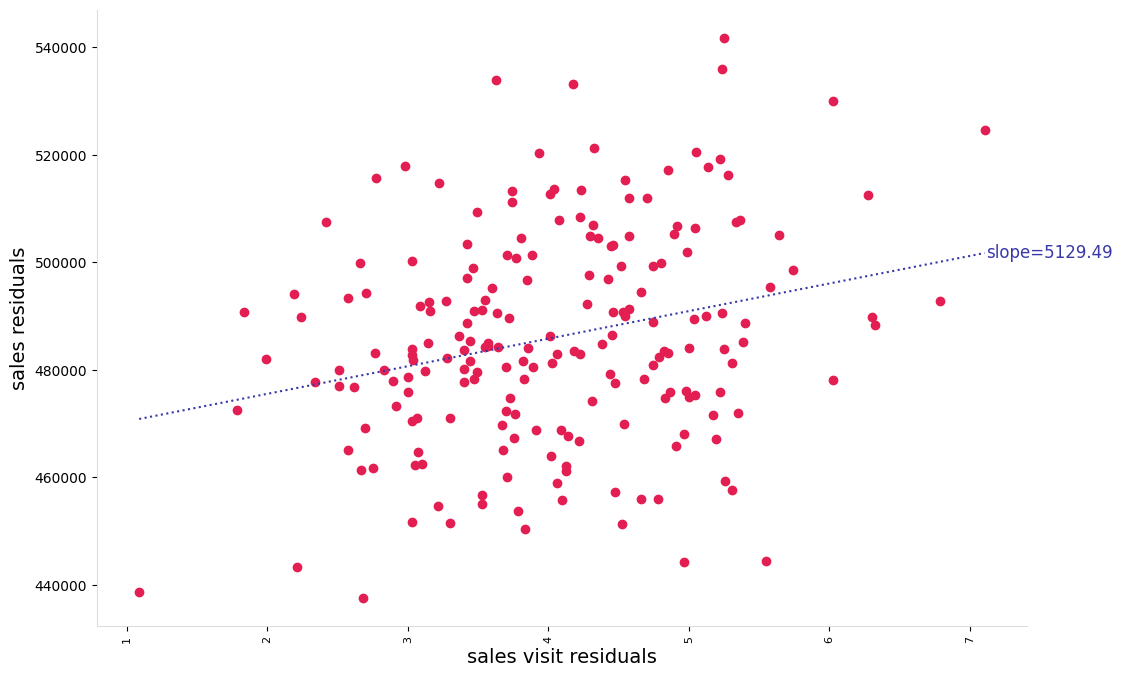

In [ ]:
regplot(x=df.sort_values('salesVisitHistoryResiduals')['salesVisitHistoryResiduals'] + np.mean(df['salesVisit']),
        y=df.sort_values('salesVisitHistoryResiduals')['salesHistoryResiduals'] + np.mean(df['sales']),
        x_label = 'sales visit residuals',
        y_label = 'sales residuals',
        residuals=False)

## Bonus
What about skuAvailability variable. Since sku availability is independent of sales Visit, should we include it in the regression?

We don't have to, but we do get an added benefit if we do include it in the regression, because we can reduce variance by including it.

Lets try FWL again including the sku availability

In [ ]:
# step 1 - get residuals from regressing sales on visit & trx history and sku Availability
df['salesResiduals'] = smf.ols('sales ~ visitHistory + trxHistory + skuAvailability', data=df).fit().resid
# step 2 - get residuals from regressing notification on visit & trx history and sku Availability
df['salesVisitResiduals'] = smf.ols('salesVisit ~ visitHistory + trxHistory + skuAvailability', data=df).fit().resid
# step 3 - regress sales residuals on sales visit residuals
mod = smf.ols('salesResiduals ~ salesVisitResiduals', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         salesResiduals   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     234.7
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           1.85e-35
Time:                        06:24:43   Log-Likelihood:                -1978.6
No. Observations:                 200   AIC:                             3961.
Df Residuals:                     198   BIC:                             3968.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.183e-10    

The coefficient is practically the same while we have reduced the standard error by 75% from 1372 to 339.

This is something you can also do when doing A/B testing and the variance is too high, you can include a control variable which is not affected by treatment, but correlated to the outcome to reduce the variance. Typically this will be the variable of interest from a pre-treatment period, but in this case we know that dayofweek is not related to the treatment, but correlated to the outcome. https://dl.acm.org/doi/abs/10.1145/2433396.2433413

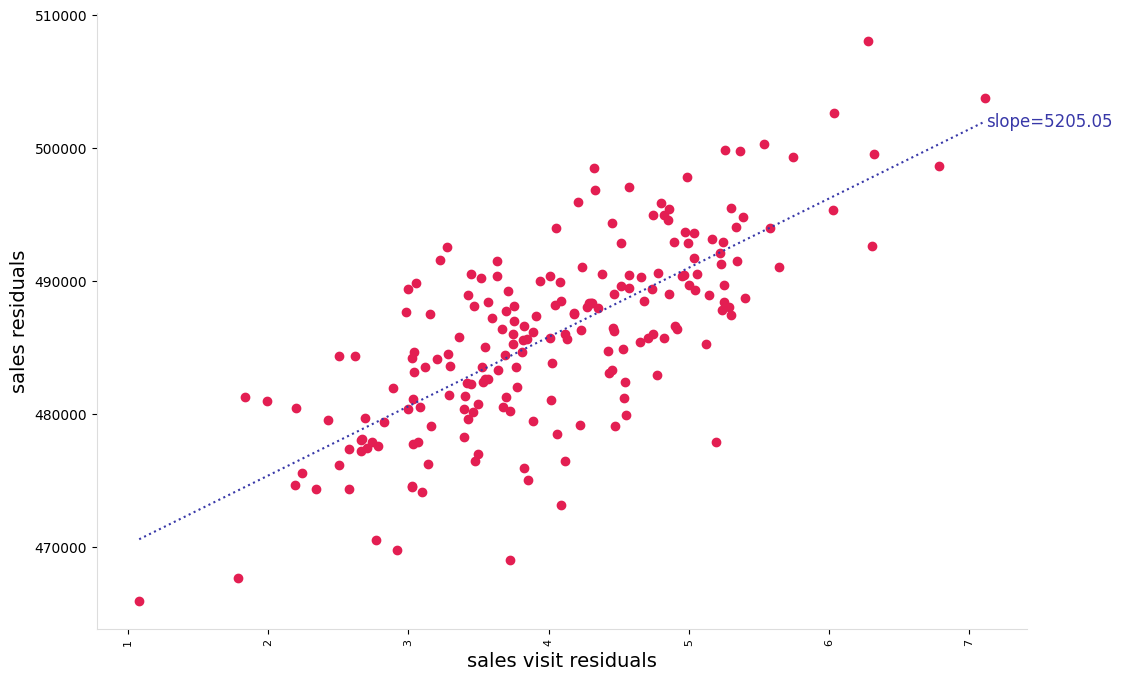

In [ ]:
regplot(x=df.sort_values('salesVisitResiduals')['salesVisitResiduals']+np.mean(df['salesVisit']),
        y=df.sort_values('salesVisitResiduals')['salesResiduals']+np.mean(df['sales']),
        x_label = 'sales visit residuals',
        y_label = 'sales residuals',
        residuals = False)

much less noise isn't it!!